In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
%config Completer.use_jedi = False

# Inception Model을 100% 구현하는 것이 아닌 1x1 convolution, concatenate와 같은 중요한 포인트만 구현했다.
* 따라서 제한적으로 구현된 한계로 인해 성능은 좋지 않다.

### Inception 모듈 함수 구조

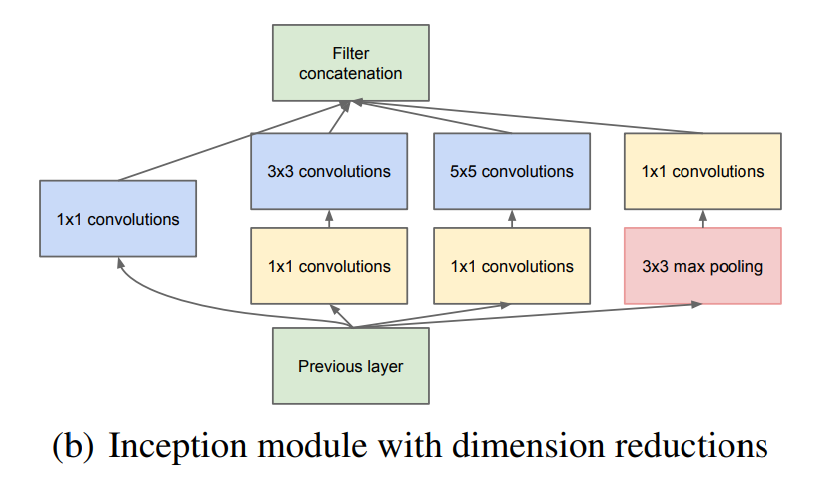

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, Concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5,
                    filters_pool_proj, name=None):
    '''
    x: 입력 Tensor / 상단 이미지에서 보면 previous layer에 해당
    filters_1x1: 단독 1x1 필터 수
    filters_3x3_reduce: 3x3 Conv 적용 전 1x1 Conv 필터 수
    filters_3x3: 3x3 Conv 필터 수
    filters_5x5_reduce: 5x5 Conv 적용 전 1x1 Conv 필터 수
    filters_5x5: 5x5 Conv 필터 수
    filters_pool_proj: MaxPooling 적용 후 1x1 Conv 필터 수
    '''
    
    # 1번 
    conv_1x1 = Conv2D(filters_1x1, (1,1), padding='same', activation='relu')(x)
    
    # 3x3 적용 전에 1x1 conv -> 3x3 conv
    conv_3x3 = Conv2D(filters_3x3_reduce, (1,1), padding='same', activation='relu')(x)
    conv_3x3 = Conv2D(filters_3x3, (3,3), padding='same', activation='relu')(conv_3x3)
    
    # 5x5 적용 전에 1x1 conv -> 5x5 conv
    conv_5x5 = Conv2D(filters_5x5_reduce, (1,1), padding='same', activation='relu')(x)
    conv_5x5 = Conv2D(filters_5x5, (5,5), padding='same', activation='relu')(conv_5x5)
    
    pool_proj = MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1,1), padding='same', activation='relu')(pool_proj)
    
    # 위에서 각각 적용한 conv 연산을 합친다.
    output = Concatenate(axis=-1, name=name)([conv_1x1, conv_3x3, conv_5x5, pool_proj])
    return output

2024-03-09 08:26:45.061439: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-09 08:26:45.061547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-09 08:26:45.186960: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Inpection Module 구조 확인하기

In [4]:
input_tensor = Input(shape=(224,224, 3))

x = Conv2D(64, (7,7), padding='same', strides=(2,2), activation='relu', name='conv_1_7x7_2')(input_tensor)
x = MaxPooling2D((3,3), padding='same',strides=(2,2), name='max_pool_1_3x3_2')(x)
x = Conv2D(64, (1,1), padding='same', strides=(1,1), activation='relu', name='conv_2a_3x3_1')(x)
x = Conv2D(192, (1,1), padding='same', strides=(1,1), activation='relu', name='conv_2b_3x3_1')(x)
x = MaxPooling2D((3,3), padding='same', strides=(2,2), name='max_pool_2_3x3_2')(x)

x = inception_module(x, filters_1x1=64,
                    filters_3x3_reduce=96,
                    filters_3x3=128,
                    filters_5x5_reduce=16,
                    filters_5x5=32,
                    filters_pool_proj=32,
                    name='inception_3a')

model = Model(inputs=input_tensor, outputs=x)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1_7x7_2        │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pool_1_3x3_2    │ (None, 56, 56,    │          0 │ conv_1_7x7_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2a_3x3_1       │ (None, 56, 56,    │      4,160 │ max_pool_1_3x3_2… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2b_3x3_1       │ (None, 56, 56,    │     12,480 │ conv_2a_3x3_1[0]… │
│ (Conv2D)            │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pool_2_3x3_2    │ (None, 28, 28,    │          0 │ conv_2b_3x3_1[0]… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     18,528 │ max_pool_2_3x3_2… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │      3,088 │ max_pool_2_3x3_2… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 28, 28,    │          0 │ max_pool_2_3x3_2… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │     12,352 │ max_pool_2_3x3_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │    110,720 │ conv2d_1[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │     12,832 │ conv2d_3[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 28, 28,    │      6,176 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3a        │ (None, 28, 28,    │          0 │ conv2d[0][0],     │
│ (Concatenate)       │ 256)              │            │ conv2d_2[0][0],   │
│                     │                   │            │ conv2d_4[0][0],   │
│                     │                   │            │ conv2d_5[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 189,808 (741.44 KB)

 Trainable params: 189,808 (741.44 KB)

 Non-trainable params: 0 (0.00 B)

### Inception Module을 사용하여 GoogleNet 생성

In [5]:
def create_googlenet(in_shape=(224,224,3), n_classes=10):
    input_tensor = Input(shape=in_shape)
    
    x = Conv2D(64, (7, 7), padding='same', strides=(2,2), activation='relu', name='conv_1_7x7_2')(input_tensor)
    x = MaxPooling2D((3,3), padding='same', strides=(2,2), name='max_pool_1_3x3_2')(x)
    x = Conv2D(64, (1, 1), padding='same', strides=(1,1), activation='relu', name='conv_2a_3x3_1')(x)
    x = Conv2D(192, (3, 3), padding='same', strides=(1,1), activation='relu', name='conv_2b_3x3_1')(x)
    x = MaxPooling2D((3,3), padding='same', strides=(2,2), name='max_pool_2_3x3_2')(x)
    
    # 첫 번째 inception 모듈
    x = inception_module(x, filters_1x1=64,
                         filters_3x3_reduce=96,
                         filters_3x3=128,
                         filters_5x5_reduce=16,
                         filters_5x5=32,
                         filters_pool_proj=32,
                         name='inception_3a')
    
    # 두 번째 inception 모듈
    x = inception_module(x, filters_1x1=128,
                        filters_3x3_reduce=128,
                        filters_3x3=192,
                        filters_5x5_reduce=32,
                        filters_5x5=96,
                        filters_pool_proj=64,
                        name='inception_3b')
    
    x = MaxPooling2D((3,3), padding='same', strides=(2,2), name='max_pool_3_3x3_2')(x)
    
    # 세 번째 inception 모듈
    x = inception_module(x, filters_1x1=192,
                        filters_3x3_reduce=96,
                        filters_3x3=208,
                        filters_5x5_reduce=16,
                        filters_5x5=48,
                        filters_pool_proj=64,
                        name='inception_4a')
    
    # 네 번째 inception 모듈
    x = inception_module(x, filters_1x1=160,
                        filters_3x3_reduce=112,
                        filters_3x3=224,
                        filters_5x5_reduce=24,
                        filters_5x5=64,
                        filters_pool_proj=64,
                        name='inception_4b')
    
    # 다섯 번째 inception 모듈
    x = inception_module(x, filters_1x1=128,
                        filters_3x3_reduce=128,
                        filters_3x3=256,
                        filters_5x5_reduce=24,
                        filters_5x5=64,
                        filters_pool_proj=64,
                        name='inception_4c')
    
    # 여섯 번째 inception 모듈
    x = inception_module(x,
                         filters_1x1=112,
                         filters_3x3_reduce=144,
                         filters_3x3=288,
                         filters_5x5_reduce=32,
                         filters_5x5=64,
                         filters_pool_proj=64,
                         name='inception_4d')
    # 일곱 번째 inception 모듈
    x = inception_module(x,
                         filters_1x1=256,
                         filters_3x3_reduce=160,
                         filters_3x3=320,
                         filters_5x5_reduce=32,
                         filters_5x5=128,
                         filters_pool_proj=128,
                         name='inception_4e')

    x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3_2')(x)
    
    # 여덟 번째 inception 모듈
    x = inception_module(x,
                         filters_1x1=256,
                         filters_3x3_reduce=160,
                         filters_3x3=320,
                         filters_5x5_reduce=32,
                         filters_5x5=128,
                         filters_pool_proj=128,
                         name='inception_5a')
    # 아홉번째 inception 모듈
    x = inception_module(x,
                         filters_1x1=384,
                         filters_3x3_reduce=192,
                         filters_3x3=384,
                         filters_5x5_reduce=48,
                         filters_5x5=128,
                         filters_pool_proj=128,
                         name='inception_5b')
    
    
    x = GlobalAveragePooling2D(name='avg_pool_5_3x3_1')(x)
    x = Dropout(rate=0.5)(x)
    output = Dense(n_classes, activation='softmax', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    model.summary()
    
    return model

In [6]:
model = create_googlenet((224,224,3), n_classes=10)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1_7x7_2        │ (None, 112, 112,  │      9,472 │ input_layer_1[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pool_1_3x3_2    │ (None, 56, 56,    │          0 │ conv_1_7x7_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2a_3x3_1       │ (None, 56, 56,    │      4,160 │ max_pool_1_3x3_2… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2b_3x3_1       │ (None, 56, 56,    │    110,784 │ conv_2a_3x3_1[0]… │
│ (Conv2D)            │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pool_2_3x3_2    │ (None, 28, 28,    │          0 │ conv_2b_3x3_1[0]… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │     18,528 │ max_pool_2_3x3_2… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 28, 28,    │      3,088 │ max_pool_2_3x3_2… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 28, 28,    │          0 │ max_pool_2_3x3_2… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │     12,352 │ max_pool_2_3x3_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 28, 28,    │    110,720 │ conv2d_7[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 28, 28,    │     12,832 │ conv2d_9[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 28, 28,    │      6,176 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3a        │ (None, 28, 28,    │          0 │ conv2d_6[0][0],   │
│ (Concatenate)       │ 256)              │            │ conv2d_8[0][0],   │
│                     │                   │            │ conv2d_10[0][0],  │
│                     │                   │            │ conv2d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 28, 28,    │     32,896 │ inception_3a[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 28, 28,    │      8,224 │ inception_3a[0][… │
│                     │ 32)               │            │                 

 Total params: 5,983,802 (22.83 MB)

 Trainable params: 5,983,802 (22.83 MB)

 Non-trainable params: 0 (0.00 B)

### GoogleNet으로 CIFAR10 데이터세트 학습 및 성능 테스트

In [7]:
IMAGE_SIZE = 128
BATCH_SIZE = 64

In [8]:
import tensorflow as tf

import random as python_random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import Sequence
import cv2
import sklearn

def zero_one_scaler(image):
    return image/255.0

def get_preprocessed_ohe(images, labels, pre_func=None):
    # preprocessing 함수가 입력되면 이를 이용하여 image array를 scaling 적용.
    if pre_func is not None:
        images = pre_func(images)
    # OHE 적용    
    oh_labels = to_categorical(labels)
    return images, oh_labels

# 학습/검증/테스트 데이터 세트에 전처리 및 OHE 적용한 뒤 반환 
def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021):
    # 학습 및 테스트 데이터 세트를  0 ~ 1사이값 float32로 변경 및 OHE 적용. 
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)
    
    # 학습 데이터를 검증 데이터 세트로 다시 분리
    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)
    
    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels )

from tensorflow.keras.utils import Sequence
import cv2
import sklearn

# 입력 인자 images_array labels는 모두 numpy array로 들어옴. 
# 인자로 입력되는 images_array는 전체 32x32 image array임. 
class CIFAR_Dataset(Sequence):
    def __init__(self, images_array, labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=False, pre_func=None):
        '''
        파라미터 설명
        images_array: 원본 32x32 만큼의 image 배열값. 
        labels: 해당 image의 label들
        batch_size: __getitem__(self, index) 호출 시 마다 가져올 데이터 batch 건수
        augmentor: albumentations 객체
        shuffle: 학습 데이터의 경우 epoch 종료시마다 데이터를 섞을지 여부
        '''
        # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당. 
        # 인자로 입력되는 images_array는 전체 32x32 image array임.
        self.images_array = images_array
        self.labels = labels
        self.batch_size = batch_size
        self.augmentor = augmentor
        self.pre_func = pre_func
        # train data의 경우 
        self.shuffle = shuffle
        if self.shuffle:
            # 객체 생성시에 한번 데이터를 섞음. 
            #self.on_epoch_end()
            pass
    
    # Sequence를 상속받은 Dataset은 batch_size 단위로 입력된 데이터를 처리함. 
    # __len__()은 전체 데이터 건수가 주어졌을 때 batch_size단위로 몇번 데이터를 반환하는지 나타남
    def __len__(self):
        # batch_size단위로 데이터를 몇번 가져와야하는지 계산하기 위해 전체 데이터 건수를 batch_size로 나누되, 정수로 정확히 나눠지지 않을 경우 1회를 더한다. 
        return int(np.ceil(len(self.labels) / self.batch_size))
    
    # batch_size 단위로 image_array, label_array 데이터를 가져와서 변환한 뒤 다시 반환함
    # 인자로 몇번째 batch 인지를 나타내는 index를 입력하면 해당 순서에 해당하는 batch_size 만큼의 데이타를 가공하여 반환
    # batch_size 갯수만큼 변환된 image_array와 label_array 반환. 
    def __getitem__(self, index):
        # index는 몇번째 batch인지를 나타냄. 
        # batch_size만큼 순차적으로 데이터를 가져오려면 array에서 index*self.batch_size:(index+1)*self.batch_size 만큼의 연속 데이터를 가져오면 됨
        # 32x32 image array를 self.batch_size만큼 가져옴. 
        images_fetch = self.images_array[index*self.batch_size:(index+1)*self.batch_size]
        if self.labels is not None:
            label_batch = self.labels[index*self.batch_size:(index+1)*self.batch_size]
        
        # 만일 객체 생성 인자로 albumentation으로 만든 augmentor가 주어진다면 아래와 같이 augmentor를 이용하여 image 변환
        # albumentations은 개별 image만 변환할 수 있으므로 batch_size만큼 할당된 image_name_batch를 한 건씩 iteration하면서 변환 수행. 
        # 변환된 image 배열값을 담을 image_batch 선언. image_batch 배열은 float32 로 설정. 
        image_batch = np.zeros((images_fetch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3), dtype='float32')
        
        # batch_size에 담긴 건수만큼 iteration 하면서 opencv image load -> image augmentation 변환(augmentor가 not None일 경우)-> image_batch에 담음. 
        for image_index in range(images_fetch.shape[0]):
            #image = cv2.cvtColor(cv2.imread(image_name_batch[image_index]), cv2.COLOR_BGR2RGB)
            # 원본 image를 IMAGE_SIZE x IMAGE_SIZE 크기로 변환
            image = cv2.resize(images_fetch[image_index], (IMAGE_SIZE, IMAGE_SIZE))
            # 만약 augmentor가 주어졌다면 이를 적용. 
            if self.augmentor is not None:
                image = self.augmentor(image=image)['image']
                
            # 만약 scaling 함수가 입력되었다면 이를 적용하여 scaling 수행. 
            if self.pre_func is not None:
                image = self.pre_func(image)
            
            # image_batch에 순차적으로 변환된 image를 담음.               
            image_batch[image_index] = image
        
        return image_batch, label_batch
    
    # epoch가 한번 수행이 완료 될 때마다 모델의 fit()에서 호출됨. 
    def on_epoch_end(self):
        if(self.shuffle):
            #print('epoch end')
            # 원본 image배열과 label를 쌍을 맞춰서 섞어준다. scikt learn의 utils.shuffle에서 해당 기능 제공
            self.images_array, self.labels = sklearn.utils.shuffle(self.images_array, self.labels)
        else:
            pass

In [9]:
# CIFAR10 데이터 재로딩 및 scaling/OHE 전처리 적용해서 학습/검증/테스트 데이터로 분류
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels ) = \
    get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.2, random_state=42)

print(tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_oh_labels.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
(40000, 32, 32, 3) (40000, 10) (10000, 32, 32, 3) (10000, 10) (10000, 32, 32, 3) (10000, 10)


In [10]:
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess

tr_ds = CIFAR_Dataset(tr_images, tr_oh_labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=True, pre_func= inception_preprocess)
val_ds = CIFAR_Dataset(val_images, val_oh_labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=False, pre_func= inception_preprocess)

print(next(iter(tr_ds))[0].shape, next(iter(tr_ds))[0].shape)
print(next(iter(val_ds))[0].shape, next(iter(val_ds))[1].shape)
print(next(iter(val_ds))[0][0])

(64, 128, 128, 3) (64, 128, 128, 3)
(64, 128, 128, 3) (64, 10)
[[[ 0.45098042  0.45098042  0.39607847]
  [ 0.45098042  0.45098042  0.39607847]
  [ 0.4431373   0.4431373   0.3803922 ]
  ...
  [ 0.54509807  0.5058824   0.45882356]
  [ 0.58431375  0.5529412   0.5137255 ]
  [ 0.58431375  0.5529412   0.5137255 ]]

 [[ 0.45098042  0.45098042  0.39607847]
  [ 0.45098042  0.45098042  0.39607847]
  [ 0.4431373   0.4431373   0.3803922 ]
  ...
  [ 0.54509807  0.5058824   0.45882356]
  [ 0.58431375  0.5529412   0.5137255 ]
  [ 0.58431375  0.5529412   0.5137255 ]]

 [[ 0.45098042  0.45098042  0.39607847]
  [ 0.45098042  0.45098042  0.39607847]
  [ 0.4431373   0.4431373   0.3803922 ]
  ...
  [ 0.54509807  0.5058824   0.4666667 ]
  [ 0.58431375  0.5529412   0.5137255 ]
  [ 0.58431375  0.5529412   0.5137255 ]]

 ...

 [[-0.23921567 -0.2235294  -0.17647058]
  [-0.23921567 -0.2235294  -0.17647058]
  [-0.24705881 -0.2235294  -0.17647058]
  ...
  [-0.16862744 -0.17647058 -0.11372548]
  [-0.16862744 -0.176

In [11]:
gnet_model = create_googlenet(in_shape=(128, 128, 3), n_classes=10)

gnet_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

history = gnet_model.fit(tr_ds, epochs=10, validation_data=val_ds, callbacks=[rlr_cb, ely_cb])

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1_7x7_2        │ (None, 64, 64,    │      9,472 │ input_layer_2[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pool_1_3x3_2    │ (None, 32, 32,    │          0 │ conv_1_7x7_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2a_3x3_1       │ (None, 32, 32,    │      4,160 │ max_pool_1_3x3_2… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2b_3x3_1       │ (None, 32, 32,    │    110,784 │ conv_2a_3x3_1[0]… │
│ (Conv2D)            │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pool_2_3x3_2    │ (None, 16, 16,    │          0 │ conv_2b_3x3_1[0]… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 16, 16,    │     18,528 │ max_pool_2_3x3_2… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 16, 16,    │      3,088 │ max_pool_2_3x3_2… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 16, 16,    │          0 │ max_pool_2_3x3_2… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 16, 16,    │     12,352 │ max_pool_2_3x3_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 16, 16,    │    110,720 │ conv2d_61[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 16, 16,    │     12,832 │ conv2d_63[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 16, 16,    │      6,176 │ max_pooling2d_10… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3a        │ (None, 16, 16,    │          0 │ conv2d_60[0][0],  │
│ (Concatenate)       │ 256)              │            │ conv2d_62[0][0],  │
│                     │                   │            │ conv2d_64[0][0],  │
│                     │                   │            │ conv2d_65[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 16, 16,    │     32,896 │ inception_3a[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 16, 16,    │      8,224 │ inception_3a[0][… │
│                     │ 32)               │            │                 

 Total params: 5,983,802 (22.83 MB)

 Trainable params: 5,983,802 (22.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  3/625 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - accuracy: 0.0790 - loss: 2.3032

I0000 00:00:1709972868.540089      68 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 67ms/step - accuracy: 0.1082 - loss: 2.2914 - val_accuracy: 0.2450 - val_loss: 1.8932 - learning_rate: 0.0010
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - accuracy: 0.3119 - loss: 1.7862 - val_accuracy: 0.4175 - val_loss: 1.5143 - learning_rate: 0.0010
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - accuracy: 0.4517 - loss: 1.4602 - val_accuracy: 0.5012 - val_loss: 1.3486 - learning_rate: 0.0010
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - accuracy: 0.5359 - loss: 1.2560 - val_accuracy: 0.5683 - val_loss: 1.1765 - learning_rate: 0.0010
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 53ms/step - accuracy: 0.5909 - loss: 1.1296 - val_accuracy: 0.6132 - val_loss: 1.0771 - learning_rate: 0.0010
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - accuracy: 0.6213 - loss: 1.0416 - val_accuracy: 0.6411 - val_loss: 1.0062 - learning_rate: 0.0010
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 53ms/step - accuracy: 0.6557 - loss: 0.9665

In [12]:
test_ds = CIFAR_Dataset(test_images, test_oh_labels, batch_size=BATCH_SIZE, augmentor=None, 
                       shuffle=False, pre_func=inception_preprocess)
evaluation_result = gnet_model.evaluate(test_ds)

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6813 - loss: 0.9531
